In [222]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import h5py

import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.nn as nn

from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [223]:
"""This file tests the different signals with the PNN"""


##define the artichetcute
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(17, 10)
        self.layer2 = nn.Linear(10, 1)
        #self.layerF = nn.Linear(15, output_size) #final layer

    def forward(self, x):
        x = self.layer1(x)
        x = nn.ReLU()(x)
        x = self.layer2(x)
        x = nn.Sigmoid()(x)
        #x = nn.Softmax(dim=1)(x)
        return x

    
#loading the saved pytorch trained weights
model = Model()
model.load_state_dict(torch.load("model.pt"))
model.eval()




##for all the mass parameters, test them against the background
##need to extract the individual signal files and a background

parameters = {"m300_m100" : [392504, 300, 100, 0.112961 ],
"m200_m150" : [392502, 200, 150, 0.031584],
"m200_m100" : [392501, 200, 100, 0.0964067],
"m400_m300" : [392509, 400, 300, 0.100593],
"m400_m100" : [392507, 400, 100, 0.124578],
"m300_m250" : [392506, 300, 250, 0.032439],
"m600_m300" : [392517, 600, 300, 0.12898],
"m500_m300" : [392513, 500, 300, 0.121851],
"m700_m1" : [392518, 700, 1, 0.133081], 
"m700_m300" : [392521, 700, 300, 0.117519]}



In [224]:
#Getting the data G

OGDATA = pd.read_hdf('data.hdf5')
print(OGDATA.columns)
print(OGDATA.shape)

Index(['lep1_pt', 'lep2_pt', 'lep1_eta', 'lep2_eta', 'lep1_phi', 'lep2_phi',
       'lep1_ch', 'lep2_ch', 'lep1_type', 'lep2_type', 'et', 'channel_nr',
       'phi', 'jet_n', 'mcw', 'lep1_mass', 'lep2_mass', 'ev_mll', 'met_pt',
       'met_phi', 'ev_mt2'],
      dtype='object')
(10197997, 21)


In [225]:
#preparing the data

OGDATA = OGDATA.assign(m1= 1)
OGDATA = OGDATA.assign(m2= 1)


i = 0
j = 0
m700_m300_index = 0
for item in parameters.keys():
    #occur = int(parameters[item][3]*123954) #data distribution
    occur = int(0.1*123954) #equal distribution
    j += occur
    #print(i, j, occur)
    if item != "m700_m300":
        OGDATA.loc[i:j, 'm1'] = parameters[item][1]
        OGDATA.loc[i:j, 'm2'] = parameters[item][2]
    else:
        OGDATA.loc[i:, 'm1'] = parameters[item][1]
        OGDATA.loc[i:, 'm2'] = parameters[item][2]
        m700_m300_index = i
    i = j + 1
    

#print(OGDATA.head)

In [226]:
#getting the background
bkg = pd.read_csv("background_test.csv", sep= r'\t', engine='python')

In [227]:


bkgtest_weight = bkg['mcw'].values
bkgtest = bkg.loc[:, ~bkg.columns.isin(['channel_nr', 'label','mcw', 'lep1_type', 'lep2_type', 'et', 'phi'])]

bkgtest = bkgtest.values
    
# scale features
scaler = StandardScaler()
modelscaler = scaler.fit(bkgtest)
bkgtest = modelscaler.transform(bkgtest)
#print(bkgest.shape)


#to torch 

bkgtest = torch.from_numpy(bkgtest).float()

bkg_pred = model(bkgtest)[:, 0].detach().numpy()



##data output

data_weight = OGDATA['mcw'].values
data = OGDATA.loc[:, ~OGDATA.columns.isin(['channel_nr', 'label','mcw', 'lep1_type', 'lep2_type', 'et', 'phi'])]

data = data.values
    
# scale features
scaler = StandardScaler()
modelscaler = scaler.fit(data)
data = modelscaler.transform(data)
#print(bkgest.shape)


#to torch 

data = torch.from_numpy(data).float()

data_pred = model(data)[:, 0].detach().numpy()

print(data_weight)
print(data_pred)



#make dic to hold all scores and information. for each singal file,
#doing the same thing that was done in last part of PNN.py
scores = {}


for channel in parameters.keys():
    
    #print(channel)
    if channel != "m700_m300":
        
        signal_ = pd.read_csv(f"{channel}_test.csv", sep= r'\t', engine='python')
    else: 
        signal_ = pd.read_csv(f"m73_test.csv", sep= r'\t', engine='python')
    
    #ytest = signal_['label'].values dont need this
    
    Weight = signal_['mcw'].values
    Xtest = signal_.loc[:, ~signal_.columns.isin(['channel_nr', 'label', 'entry', 'mcw', 'lep1_type', 'lep2_type', 'et', 'phi'])]
    
    print(Xtest.shape)
    #print(Xtest.columns)
    
    Xtest = Xtest.values

    
    
    # scale features
    scaler = StandardScaler()
    modelscaler = scaler.fit(Xtest)
    Xtest = modelscaler.transform(Xtest)
    

    Xtest = torch.from_numpy(Xtest).float()

    test_pred = model(Xtest)[:, 0].detach().numpy()
    
    
    scores[channel] = []
    scores[channel].append(test_pred)
    scores[channel].append(Weight)
    

    """plt.hist(test_pred, bins = 10, label = "signal")
    plt.xlabel("Model output")
    plt.ylabel("Count")
    plt.title(f"{channel}")
    plt.legend()
    plt.show()"""
    
    
    
    
    


[0. 0. 0. ... 0. 0. 0.]
[1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.6570109e-05 3.9281440e-05
 3.7174083e-05]
(2869, 17)
(764, 17)
(2391, 17)
(2487, 17)
(3146, 17)
(853, 17)
(3118, 17)
(2958, 17)
(3355, 17)
(14567, 17)


4
2869
2869
s:  5.2087908
b:  92
s/√b :  0.5430539808039409


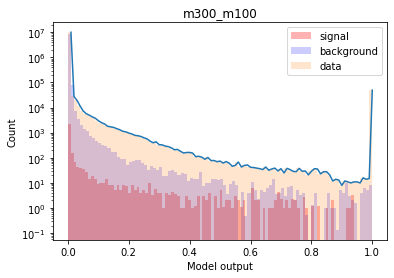

4
764
764
s:  0.0
b:  92
s/√b :  0.0


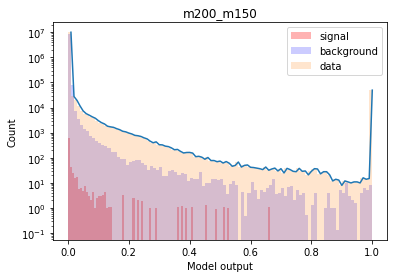

4
2391
2391
s:  3.0
b:  92
s/√b :  0.3127716210856122


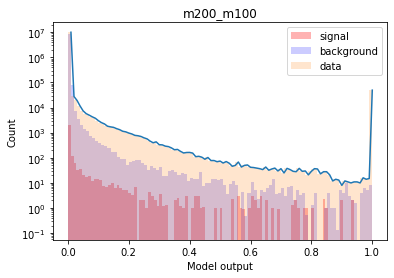

4
2487
2487
s:  0.0
b:  92
s/√b :  0.0


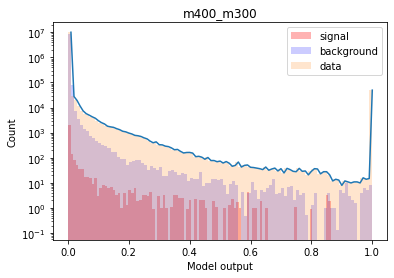

4
3146
3146
s:  17.1225064
b:  92
s/√b :  1.7851446945922564


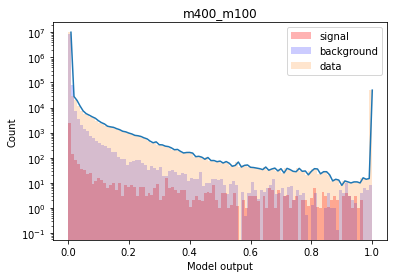

4
853
853
s:  0.0
b:  92
s/√b :  0.0


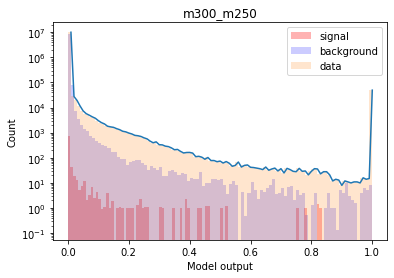

4
3118
3118
s:  11.3647218
b:  92
s/√b :  1.184854153524332


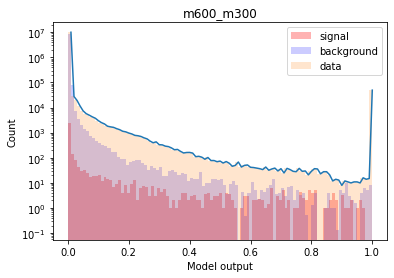

4
2958
2958
s:  5.2930466
b:  92
s/√b :  0.551838255187896


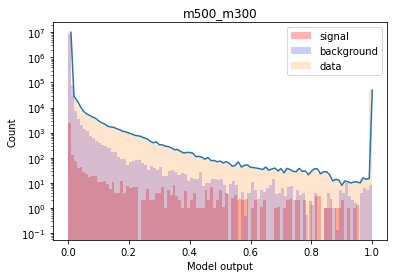

4
3355
3355
s:  22.1739571
b:  92
s/√b :  2.3117948360166065


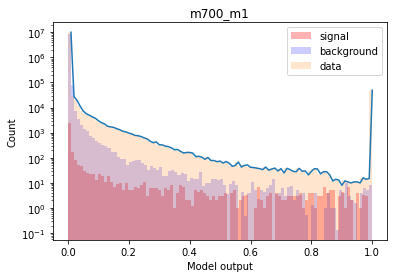

4
14567
14567
s:  59.0
b:  92
s/√b :  6.151175214683706


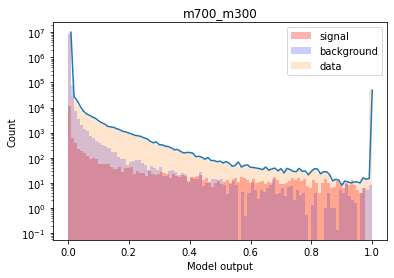

In [231]:
optimalT = 0.0016472975
optimalT = 0.96


#choosing an optimal plotting the histogram, 
#and applying a counting experiment to find the significance for each singal
b = np.sum(np.histogram(bkg_pred, range = (optimalT, 1))[0])

for channel in parameters.keys():
    score = scores[channel]
    
    print(len(score))
    print(len(score[0]))
    print(len(score[1]))
    
    plt.hist(score[0], color = "red", alpha = 0.3, label = "signal", bins = 100, weights = score[1])
    plt.hist(bkg_pred, color = "blue", alpha = 0.2, label = "background", bins = 100, weights = bkgtest_weight)
    
    
    counts, bins = np.histogram(data_pred, bins = 100 )
    #print(bins, len(bins))
    #print(counts, len(counts))
    plt.plot(bins[1:], counts)
    plt.hist(data_pred, label = "data", bins = 100, alpha = 0.2 )
    
    

    s = np.sum(np.histogram(score[0], range = (optimalT, 1), weights = score[1])[0])
    sig = s/np.sqrt(b)
    
    print("s: ", s)
    print("b: ", b)
    print("s/√b : ", sig)
    
    scores[channel].append(s)
    scores[channel].append(sig)
    
    
    plt.xlabel("Model output")
    plt.ylabel("Count")
    plt.title(f"{channel}")
    plt.yscale("log")
    plt.legend()
    plt.savefig(f"{channel}_ml_hist.pdf")
    plt.show()


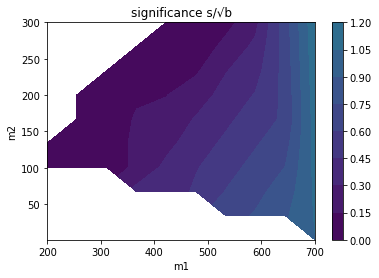

In [233]:
##making a contour significance plot

m1 = []
m2 = []
sig = []

for channel in parameters.keys():
    m1.append(parameters[channel][1])
    m2.append(parameters[channel][2])
    sig.append(scores[channel][3])


import numpy as np
from scipy.interpolate import griddata

xi = linspace(min(m1), max(m1), 10)
yi = linspace(min(m2), max(m2), 10)
zi = griddata((m1, m2), sig, (xi[None,:], yi[:,None]), method='linear')
figure = plt.contourf(xi, yi, zi)
plt.xlabel("m1")
plt.ylabel("m2")
plt.title("significance s/√b")
plt.colorbar(figure)
figure.set_clim(0.0, 3.2)
plt.savefig("significance.pdf")
plt.show()


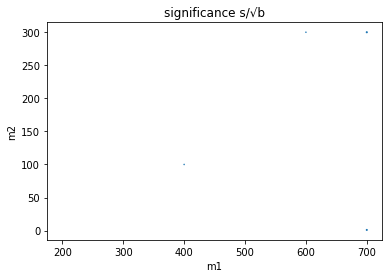

In [230]:
plt.scatter(m1, m2, sig)
plt.xlabel("m1")
plt.ylabel("m2")
plt.title("significance s/√b")
plt.show()